Created By: Shane Gervais
<br>
Assisted By: Alexander Weismann

In [17]:
from numpy import zeros, size, sqrt
import scipy.linalg as la

"""
Class to solve a poisson type elliptic equation
with form D^2 sol + fct sol = rhs 
where 
    D^2 is the flat laplace operator 
    fct and rhs are user-supplied functions of x,y,z
    sol is the solution
"""
class EllipticSolver:
    
    def __init__(self, x, y, z):

        print("Setting up the Poisson solver")

        self.n_grid = size(x)
        self.delta = x[1] - x[0]

        #Number of Grids
        n_grid = self.n_grid

        #Create 3D grid
        nnn = n_grid ** 3
        
        #1D RHS of the equ
        self.rhs_1d = zeros(nnn)

        #Create 3x3 matrix A
        self.A = zeros((nnn, nnn))
        
        self.sol = zeros((n_grid, n_grid, n_grid))
        self.rad = zeros((n_grid, n_grid, n_grid))

        #Compute the radius
        for i in range(0, n_grid):
            for j in range(0, n_grid):
                for k in range (0, n_grid):
                    rad2 = x[i]**2 + y[j]**2 + z[k]**2
                    self.rad[i, j, k] = sqrt(rad2) 
    #enf of init

    #Initializing matrix A
    def setup_matrix(self, fct):

        #Number of Grids
        n_grid = self.n_grid

        #Using Robin boundary conditions for BC
        
        #In X

        #Lower boundary
        i = 0 
        for j in range(0, n_grid):
            for k in range(0, n_grid):
                index = self.super_index(i, j, k)
                self.A[index, index] = self.rad[i, j, k]
                self.A[index, index + 1] = -self.rad[i + 1, j, k]

        #Upper Boundary
        i = n_grid - 1
        for j in range(0, n_grid):
            for k in range(0, n_grid):
                index = self.super_index(i, j, k)
                self.A[index, index] = self.rad[i, j, k]
                self.A[index, index - 1] = -self.rad[i - 1, j, k]

        #In Y

        #Lower boundary
        j = 0 
        for i in range(1, n_grid - 1):
            for k in range(0, n_grid):
                index = self.super_index(i, j, k)
                self.A[index, index] = self.rad[i, j, k]
                self.A[index, index + n_grid] = -self.rad[i, j + 1, k]

        #Upper Boundary
        j = n_grid - 1
        for i in range(1, n_grid - 1):
            for k in range(0, n_grid):
                index = self.super_index(i, j, k)
                self.A[index, index] = self.rad[i, j, k]
                self.A[index, index - n_grid] = -self.rad[i, j - 1, k]

        #In Z

        #Lower boundary
        k = 0 
        for i in range(1, n_grid - 1):
            for j in range(1, n_grid - 1):
                index = self.super_index(i, j, k)
                self.A[index, index] = self.rad[i, j, k]
                self.A[index, index + n_grid * n_grid] = -self.rad[i, j, k + 1]

        #Upper Boundary
        k = n_grid - 1
        for i in range(1, n_grid - 1):
            for j in range(1, n_grid - 1):
                index = self.super_index(i, j, k)
                self.A[index, index] = self.rad[i, j, k]
                self.A[index, index - n_grid * n_grid] = -self.rad[i, j, k - 1]

        #Filling matrix
        for i in range(1, n_grid - 1):
            for j in range(1, n_grid - 1):
                for k in range(1, n_grid - 1):
                    
                    index = self.super_index(i, j, k)

                    #diagonal
                    self.A[index, index] = -6. + self.delta**2 *fct[i, j, k]

                    #off diagonal
                    self.A[index, index - 1] = 1.0
                    self.A[index, index + 1] = 1.0
                    self.A[index, index - n_grid] = 1.0
                    self.A[index, index + n_grid] = 1.0
                    self.A[index, index - n_grid * n_grid] = 1.0
                    self.A[index, index + n_grid * n_grid] = 1.0

    #matrix A setup end

    #initialize RHS of equation
    def setup_rhs(self, rhs):
        
        n_grid = self.n_grid

        for i in range(1, n_grid - 1):
            for j in range(1, n_grid - 1):
                for k in range(1, n_grid - 1):
                    index = self.super_index(i, j, k)
                    self.rhs_1d[index] = self.delta**2 *rhs[i, j, k]

    #Uses scipy.linalg matrix solver and return our sol in 3D
    def solve(self):
        
        #solve in 1D
        sol_1d = la.solve(self.A, self.rhs_1d)

        #then

        #translate to 3D
        for i in range(0, self.n_grid):
            for j in range(0, self.n_grid):
                for k in range(0, self.n_grid):
                    index = self.super_index(i, j, k)
                    self.sol[i, j, k] = sol_1d[index]

        return self.sol

    #Using super indices i + Nj + N^2k
    def super_index(self, i, j, k):
        return i + self.n_grid * (j + self.n_grid*k)

In [20]:
from numpy import zeros, sqrt, linspace
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


"""
This class creates the initial data for our blackhole puncture.
Initial data is used at arguments and then we call the constructed 
solution
"""

class Puncture:

    """
    Arguments for the constructor:
        location of puncture -> bh_loc
        linear momentum -> lin_mom
        size of grid -> n_grid
        outer boundary -> x_out
    """
    def __init__(self, bh_loc, lin_mom, n_grid, x_out):

        #Initialize arguments
        self.bh_loc = bh_loc
        self.lin_mom = lin_mom
        self.n_grid = n_grid
        self.x_out = x_out
        self.delta = 2.0*x_out/n_grid

        #Echo parameters
        print("Constructing class Puncture for single black hole")
        print("     at location = (", bh_loc[0], ", ", bh_loc[1], ", ", bh_loc[2], ")")
        print("     with momentum p = (", lin_mom[0], ", ", lin_mom[1], ", ", lin_mom[2], ")")
        print("Using ", n_grid, "\b^3 gridpoints with outer boundar at ", x_out)

        half_delta = self.delta/2.0

        self.x = linspace(half_delta - x_out, x_out - half_delta, n_grid)
        self.y = linspace(half_delta - x_out, x_out - half_delta, n_grid)
        self.z = linspace(half_delta - x_out, x_out - half_delta, n_grid)

        #allocate the elliptic solver
        self.solver = EllipticSolver(self.x, self.y, self.z)


        #allocate functions u, alpha, beta and residual
        self.alpha = zeros((n_grid, n_grid, n_grid))
        self.beta = zeros((n_grid, n_grid, n_grid))
        self.u = zeros((n_grid, n_grid, n_grid))
        self.res = zeros((n_grid, n_grid, n_grid))

    #Construct our solutions
    def construct_solution(self, tol, it_max):

        self.setup_alpha_beta()
        residual_norm = self.residual()
        print("Initial Residual = ", residual_norm)
        print("Using up to ", it_max, "iteration steps to reach a tolerance of", tol)

        #iterate
        it_steps = 0
        
        while residual_norm > tol and it_steps < it_max:
            it_steps += 1
            self.update_u()
            residual_norm = self.residual()
            print("Residual after= ", it_steps, "iterations:", residual_norm)

        if (residual_norm < tol):
            print("Done!")

        else:
            print("Giving up")

    #Updates using poisson solver
    def update_u(self):
        
        #Initialize variables
        n_grid = self.n_grid
        fct = zeros((n_grid, n_grid, n_grid))
        rhs = zeros((n_grid, n_grid, n_grid))

        #h'(u^[n]) = 7*alpha*beta*(alpha + alpha*u^[n] +1)^-8
        for i in range(1, n_grid - 1):
            for j in range(1, n_grid - 1):
                for k in range(1, n_grid - 1):
                    temp = self.alpha[i, j, k]*(1.0 + self.u[i, j, k]) + 1.0
                    fct[i, j, k] = (-7.0*self.beta[i, j, k]*self.alpha[i, j, k]/ temp**8)
                    rhs[i, j, k] = -self.res[i, j, k]

        #update poisson solver
        self.solver.setup_matrix(fct)

        #setup rhs
        self.solver.setup_rhs(rhs)

        #solve for delta_u
        #i.e. D^2(delat_u) - h'(u^[n])(delta_u) = - R^[n]
        delta_u = self.solver.solve()

        #now update u
        self.u += delta_u

    #Calculate the residual
    #by R^[n] = (D^2)u^[n] - h(u^[n])
    def residual(self):

        #initialize
        residual_norm = 0.0
        n_grid = self.n_grid

        for i in range(1, n_grid - 1):
            for j in range(1, n_grid - 1):
                for k in range(1, n_grid - 1):

                    #lhs for laplace operator
                    ddx = (self.u[i + 1, j, k] - 2.0*self.u[i, j, k] + self.u[i - 1, j, k])
                    ddy = (self.u[i, j + 1, k] - 2.0*self.u[i, j, k] + self.u[i, j - 1, k])
                    ddz = (self.u[i, j, k + 1] - 2.0*self.u[i, j, k] + self.u[i, j, k - 1])

                    lhs = (ddx + ddy + ddz)/self.delta**2

                    #rhs
                    temp = self.alpha[i, j, k]*(1.0 + self.u[i, j, k]) + 1.0
                    rhs = -self.beta[i, j, k]/temp**7


                    self.res[i, j, k] = lhs - rhs
                    residual_norm += self.res[i, j, k]**2

        residual_norm = sqrt(residual_norm) * self.delta**3
        return residual_norm


    def setup_alpha_beta(self):
        n_grid = self.n_grid

        #Initialize momentum with given arguments
        pX = self.lin_mom[0]
        pY = self.lin_mom[1]
        pZ = self.lin_mom[2]

        for i in range(0, n_grid):
            for j in range(0, n_grid):
                for k in range(0, n_grid):
                    sX = self.x[i] - self.bh_loc[0]
                    sY = self.y[i] - self.bh_loc[1]
                    sZ = self.z[i] - self.bh_loc[2]
                    s2 = sX**2 + sY**2 + sZ**2
                    s_bh = sqrt(s2)

                    lX = sX/s_bh
                    lY = sY/s_bh
                    lZ = sZ/s_bh

                    lP = lX*pX + lY*pY + lZ*pZ

                    #Construct curvature
                    #A^[i,j]_L = (3/2s^2)((P^i)(l^j) + (P^j)(l^i) - (n^ij -(l^i)(l^j))l_k(P^k))
                    fac = 3.0/(2.0*s2)
                    
                    Axx = fac*(2.0*pX*lX - (1.0 - lX*lX)*lP)
                    Ayy = fac*(2.0*pY*lY - (1.0 - lY*lY)*lP)
                    Azz = fac*(2.0*pZ*lZ - (1.0 - lZ*lZ)*lP)

                    Axy = fac*(pX*lY + pY*lX + lX*lY*lP)
                    Axz = fac*(pX*lZ + pZ*lX + lX*lZ*lP)

                    Ayz = fac*(pY*lZ + pZ*lY + lY + lY * lZ *lP)

                    #Compute A
                    A2 = (Axx**2 + Ayy**2 + Azz**2 + 2.0*(Axy**2 + Axz**2 + Ayz**2))


                    #now for alpha and beta
                    #1/alpha = sum(M_n/2s_n)
                    #beta = (1/8)(alpha^7)A^L_ij*A^ij_L
                    self.alpha[i, j, k] = 2.0*s_bh
                    self.beta[i, j, k] = self.alpha[i, j, k]**7 * A2/8.0

    #end of setup for alpha and beta

    #output to a file
    def write_to_file(self):

        n_grid = self.n_grid
        x_out = self.x_out
        
        #create a file
        filename = "Puncture_" + str(n_grid) + "_" + str(x_out)
        filename = filename + ".csv"
        out = open(filename, "w")

        if out:
            k = n_grid//2

            #out.write("#Data for black hole at x (%f,%f,%f)\n" % (bh_loc[0], bh_loc[1], bh_loc[2]))
            #out.write("#with linear momentum p = (%f,%f,%f)\n" % (lin_mom))
            #out.write("#in plane for z = %e \n" % (self.z[k]))
            #out.write("#x            y              u               \n")
            #out.write("#============================================\n")

            for i in range(0, n_grid):
                for j in range(0, n_grid):
                    out.write("%e, %e, %e\n" % (self.x[i], self.y[j], self.u[i, j, k]))
                    
            out.close()
        
        else:
            print("Could not open file", filename, "in write_to_file()")
            print("permission error?")
    #end write file

    def plot(self):

        n_grid = self.n_grid
        x_out = self.x_out

        filename = "Puncture_" + str(n_grid) + "_" + str(x_out)
        filename = filename + ".csv"

        '''
        Use this as a simpler way or keep what i had which scrapes your directory for all .csv files and takes the first one
        df = pd.read_csv('"FILE PATH HERE".csv',names=['x','y','u'])
        '''
        try:
            df = pd.read_csv(filename, names=['x','y','u'])
        except:
            print(f'No file name {filename} found!')
    
   
        x = df['x'].values
        y = df['y'].values
        z = df['u'].values

        n_grid = int(np.sqrt(x.size))
        X = np.reshape(x, (n_grid, n_grid))
        Y = np.reshape(y, (n_grid, n_grid))
        Z = np.reshape(z, (n_grid, n_grid))

        #scatter
        """
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, c='r', marker='o')

        """

        #surface
        ax = plt.axes(projection='3d')
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='ocean', edgecolor='none')

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("u")
    
        plt.show()
    


Blackhole initial data puncture, use flag -h for options
Constructing class Puncture for single black hole
     at location = ( 0.0 ,  0.0 ,  0.0 )
     with momentum p = ( 1.0 ,  1.0 ,  1.0 )
Using  16^3 gridpoints with outer boundar at  4.0
Setting up the Poisson solver
Initial Residual =  2.164834629326835
Using up to  50 iteration steps to reach a tolerance of 1e-12
Residual after=  1 iterations: 0.6157071503184104
Residual after=  2 iterations: 0.10628393343966588
Residual after=  3 iterations: 0.004186516418725883
Residual after=  4 iterations: 6.4024750809471475e-06
Residual after=  5 iterations: 1.4605093016658383e-11
Residual after=  6 iterations: 2.4796440740230126e-15
Done!


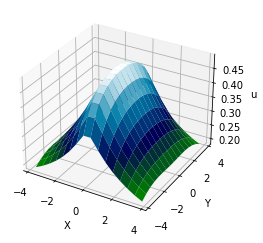

In [21]:
"""
BlackholePunctures by Shane Gervais
last updated: 2022/07/18

This code is the main driver for EllipticSolver.py and Puncture.py
to construct the initial puncture data of a singular
blackhole. 

Use flag -h for list of options

These files are referenced by Numerical Relativity Starting 
from Scratch by Thomas W. Baumgarte and Stuart L. Shapiro
"""

import sys

print("======================================================================")
print("Blackhole initial data puncture, use flag -h for options")
print("======================================================================")

def usage():
    print("Construct the initial puncture data for a single black hole")
    print("Options are:")
    print("to change number of grids with -n_grid")
    print("to change location of outer boundary with -x_out")
    print("to change tolerance with -tol")
    print("to change maximum iterations with -it_max")
    print("to change location of x, y or z with -loc along with position X,Y or Z")
    print("to change momentum of x, y or z with -p along with position X,Y or Z")
    print("Otherwise the program will follow default values")


#set default values
locX = 0.0
locY = 0.0
locZ = 0.0

#momentum of blackhole
pX = 1.0
pY = 1.0
pZ = 1.0

#number of grids
n_grid = 16

#location of outer boundary
x_out = 4.0

#tolerance and maximum number of iterations
tol = 1.0e-12
it_max = 50

#flag options
for i in range(len(sys.argv)):

    if sys.argv[i] == "-h":
        usage()
    

    if sys.argv[i] == "-n_grid":
        n_grid = int(sys.argv[i+1])

    if sys.argv[i] == "-x_out":
        x_out = float(sys.argv[i+1])

    if sys.argv[i] == "-locX":
        locX = float(sys.argv[i+1])

    if sys.argv[i] == "-locY":
        locY = float(sys.argv[i+1])

    if sys.argv[i] == "-locZ":
        locZ = float(sys.argv[i+1])

    if sys.argv[i] == "-pX":
        pX = float(sys.argv[i+1])

    if sys.argv[i] == "-pY":
        pY = float(sys.argv[i+1])

    if sys.argv[i] == "-pZ":
        pZ = float(sys.argv[i+1])

    if sys.argv[i] == "-tol":
        tol = float(sys.argv[i+1])

    if sys.argv[i] == "-it_max":
        it_max = int(sys.argv[i+1])

#location of puncture
bh_loc = (locX, locY, locZ)

#linear momentum
lin_mom = (pX, pY, pZ)

#puncture solver
blackHole = Puncture(bh_loc, lin_mom, n_grid, x_out)

#Construct solution
blackHole.construct_solution(tol, it_max)

#write to file
blackHole.write_to_file()

#plot results
blackHole.plot()



In [ ]:
'''
TODO:   -Add user inputed location and momentum data through and interface (bh_loc, lin_mom, n_grid, x_out)
        -Show result below
'''